In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [4]:
import tensorflow as tf
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
# Load the dataset
df = pd.read_csv('stocks_data.csv')

In [8]:
msft_data = df[df['symbol'] == 'MSFT']
close_prices = msft_data.reset_index()['close']

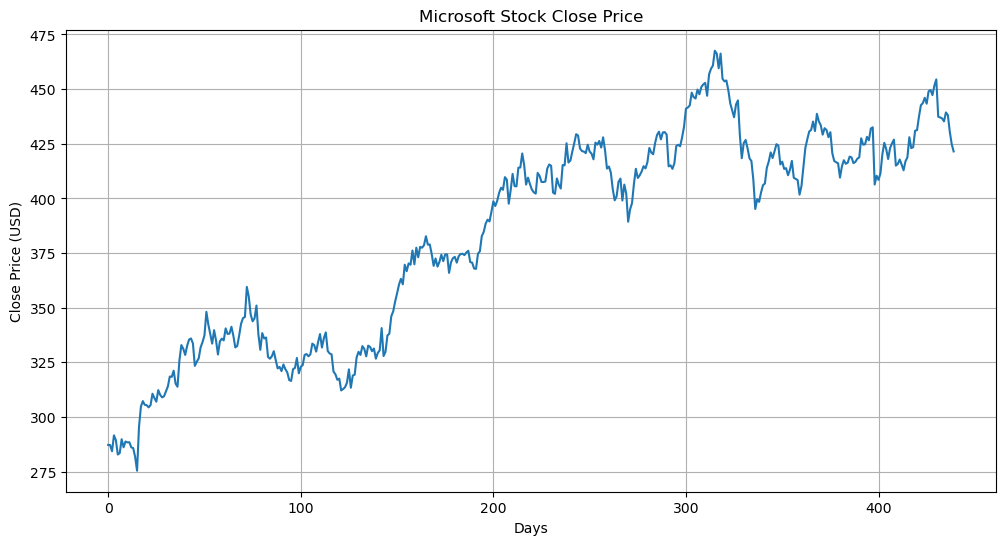

In [10]:
#original close price data
plt.figure(figsize=(12, 6))
plt.title('Microsoft Stock Close Price')
plt.plot(close_prices)
plt.xlabel('Days')
plt.ylabel('Close Price (USD)')
plt.grid(True)
plt.show()

In [12]:
# Scaling the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(close_prices).reshape(-1, 1))

In [14]:
# Using 80% of data for training, 20% for testing
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :1]

In [16]:
print(f"Training data size: {train_size} days")
print(f"Testing data size: {test_size} days")

Training data size: 352 days
Testing data size: 88 days


In [18]:
# 4. Creating dataset with time steps
def create_dataset(dataset, time_step=1):
    """
    Convert an array of values into a dataset matrix.
    
    Args:
        dataset: Array of values
        time_step: Number of previous time steps to use as input features
        
    Returns:
        X: Training features with shape (n_samples, time_step)
        y: Target values
    """
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        # Extracting 'time_step' number of previous values
        X.append(dataset[i:(i + time_step), 0])
        # The next value becomes the target
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

#lookback period (number of previous days to consider)
time_step = 80

In [20]:
#training and testing datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (271, 80), y_train shape: (271,)
X_test shape: (7, 80), y_test shape: (7,)


In [22]:
# 5. Reshaping input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# 6.LSTM model
model = Sequential()
# First LSTM layer with 50 units, return sequences for stacking another LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# Second LSTM layer with 50 units, return sequences for stacking another LSTM layer
model.add(LSTM(50, return_sequences=True))
# Third LSTM layer with 50 units
model.add(LSTM(50))
# Output layer with 1 neuron for regression
model.add(Dense(1))
# Compiling the model using mean squared error as loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/Users/dinakarreddy/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Fit the model with training data and validate using testing data
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2980 - val_loss: 0.0386
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0293 - val_loss: 0.0105
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0163 - val_loss: 0.0510
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0269 - val_loss: 0.0095
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0144 - val_loss: 0.0018
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0093 - val_loss: 0.0016
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0073 - val_loss: 0.0011
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0060 - val_lo

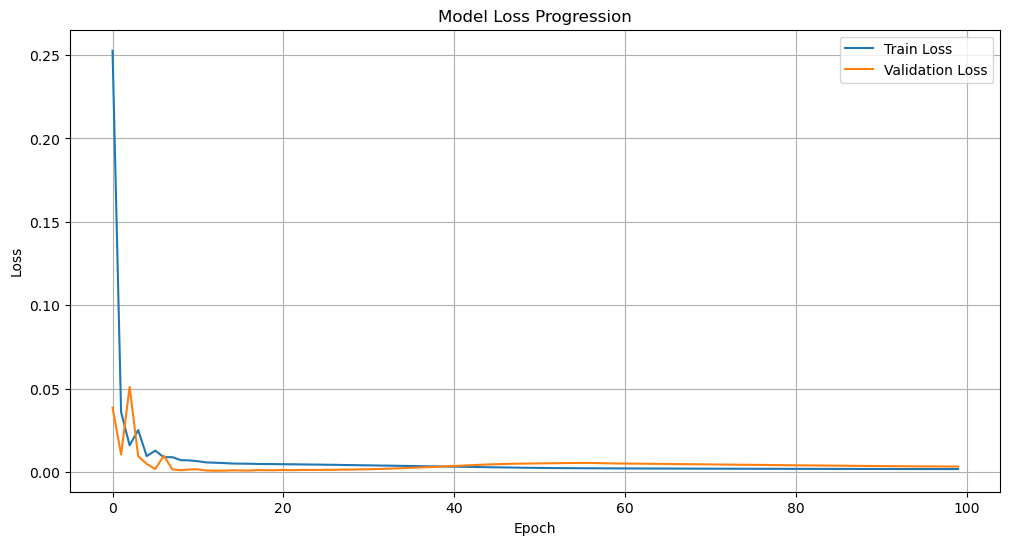

In [28]:
#training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [30]:
#Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform to get actual prices
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Scale back the y values for comparison
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [32]:
# performance metrics
#RMSE for training data
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predictions))
print(f'Training RMSE: {train_rmse:.2f}')
#RMSE for testing data
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predictions))
print(f'Testing RMSE: {test_rmse:.2f}')
#MAPE for training and testing data
train_mape = np.mean(np.abs((y_train_actual - train_predictions) / y_train_actual)) * 100
test_mape = np.mean(np.abs((y_test_actual - test_predictions) / y_test_actual)) * 100
print(f'Training MAPE: {train_mape:.2f}%')
print(f'Testing MAPE: {test_mape:.2f}%')

Training RMSE: 8.14
Testing RMSE: 11.02
Training MAPE: 1.68%
Testing MAPE: 2.16%


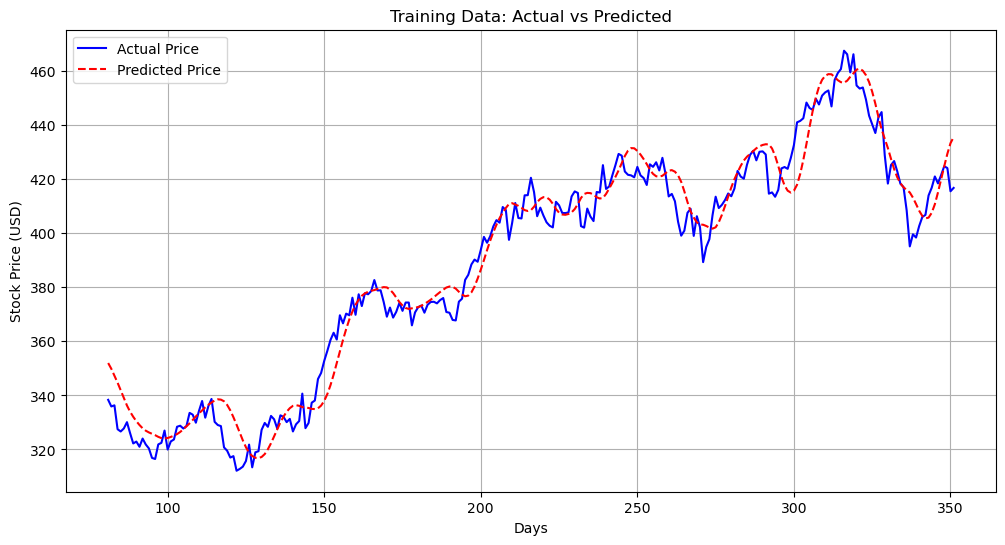

In [34]:
# training predictions
plt.figure(figsize=(12, 6))
plt.title('Training Data: Actual vs Predicted')
# Creating a time axis for the training data
# Offset by time_step since we used that many days as features
train_time = np.arange(time_step + 1, len(train_data))
plt.plot(train_time, y_train_actual, 'b', label='Actual Price')
# Adjusting the prediction time to match the actual data points
prediction_time = np.arange(time_step + 1, len(train_predictions) + time_step + 1)
plt.plot(prediction_time, train_predictions, 'r--', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

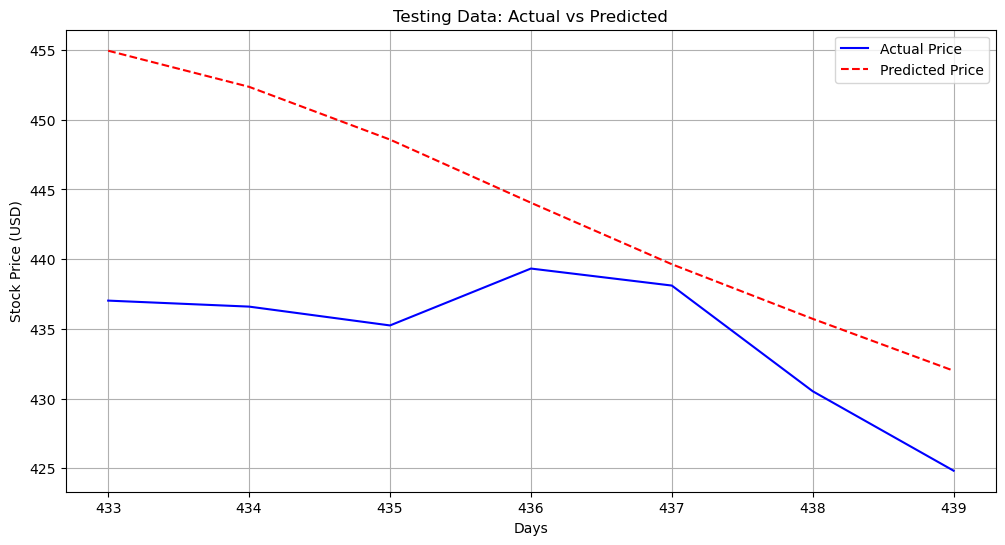

In [36]:
#testing predictions
plt.figure(figsize=(12, 6))
plt.title('Testing Data: Actual vs Predicted')

# Creating a time axis for the test data
test_time = np.arange(train_size + time_step + 1, len(scaled_data))
plt.plot(test_time, y_test_actual, 'b', label='Actual Price')

# Adjusting the prediction time to match the actual data points
test_prediction_time = np.arange(train_size + time_step + 1, len(test_predictions) + train_size + time_step + 1)
plt.plot(test_prediction_time, test_predictions, 'r--', label='Predicted Price')

plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# 12. Future predictions
def predict_future(model, last_sequence, n_steps, n_features=1, n_days=20):
    """
    Predict future values using a trained model.
    
    Args:
        model: Trained LSTM model
        last_sequence: Last sequence of known values
        n_steps: Number of time steps used in training
        n_features: Number of features
        n_days: Number of days to predict into future
        
    Returns:
        Array of predicted values
    """
    future_predictions = []
    
    if isinstance(last_sequence, np.ndarray):
        input_sequence = last_sequence.tolist()
    else:
        input_sequence = list(last_sequence)
    
    # copy to avoid modifying the original
    current_sequence = input_sequence.copy()
    
    # Predict n_days into the future
    for _ in range(n_days):
        # Take the last n_steps elements
        if len(current_sequence) > n_steps:
            x_input = np.array(current_sequence[-n_steps:])
        else:
            x_input = np.array(current_sequence)
            
        # Reshape for prediction
        x_input = x_input.reshape((1, len(x_input), n_features))
        
        # Make prediction (next day)
        next_day_price = model.predict(x_input, verbose=0)
        
        # Append prediction to our sequence
        current_sequence.append(next_day_price[0, 0])
        future_predictions.append(next_day_price[0, 0])
    
    return np.array(future_predictions).reshape(-1, 1)

In [40]:
# Getting the last known sequence from test data
last_known_sequence = test_data.flatten()

In [42]:
# Predicting next 20 days
future_days = 20
future_predictions = predict_future(
    model, 
    last_known_sequence, 
    time_step, 
    n_features=1, 
    n_days=future_days
)

In [44]:
# Convert predictions back to original scale
future_predictions_actual = scaler.inverse_transform(future_predictions)

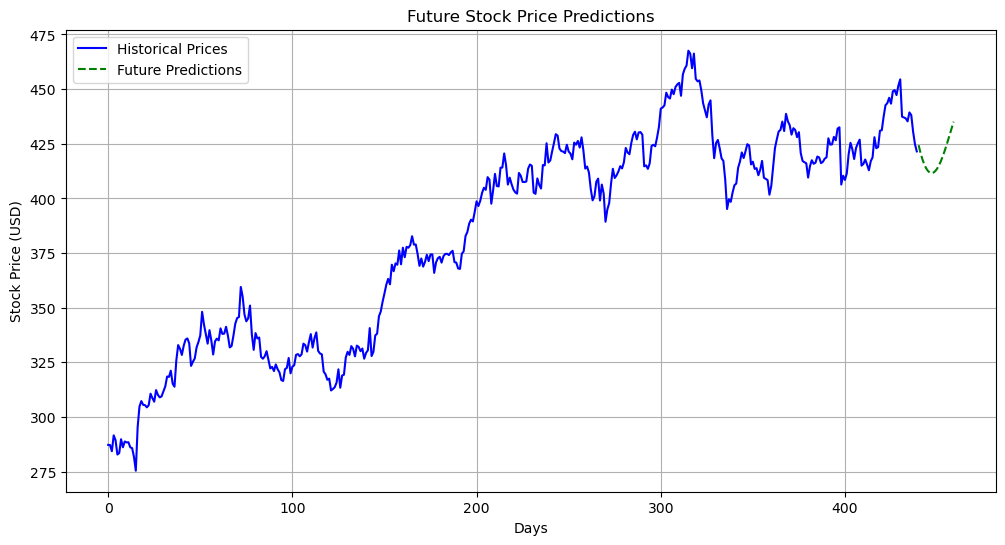

In [46]:
#future predictions
last_date_idx = len(scaled_data) - 1
future_date_range = np.arange(last_date_idx + 1, last_date_idx + future_days + 1)

plt.figure(figsize=(12, 6))
plt.title('Future Stock Price Predictions')

#known data
plt.plot(np.arange(len(close_prices)), scaler.inverse_transform(scaled_data), 'b', label='Historical Prices')

#future predictions
plt.plot(future_date_range, future_predictions_actual, 'g--', label='Future Predictions')

plt.xlabel('Days')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

January Prediction RMSE: 15.32
January Prediction MAPE: 3.09%


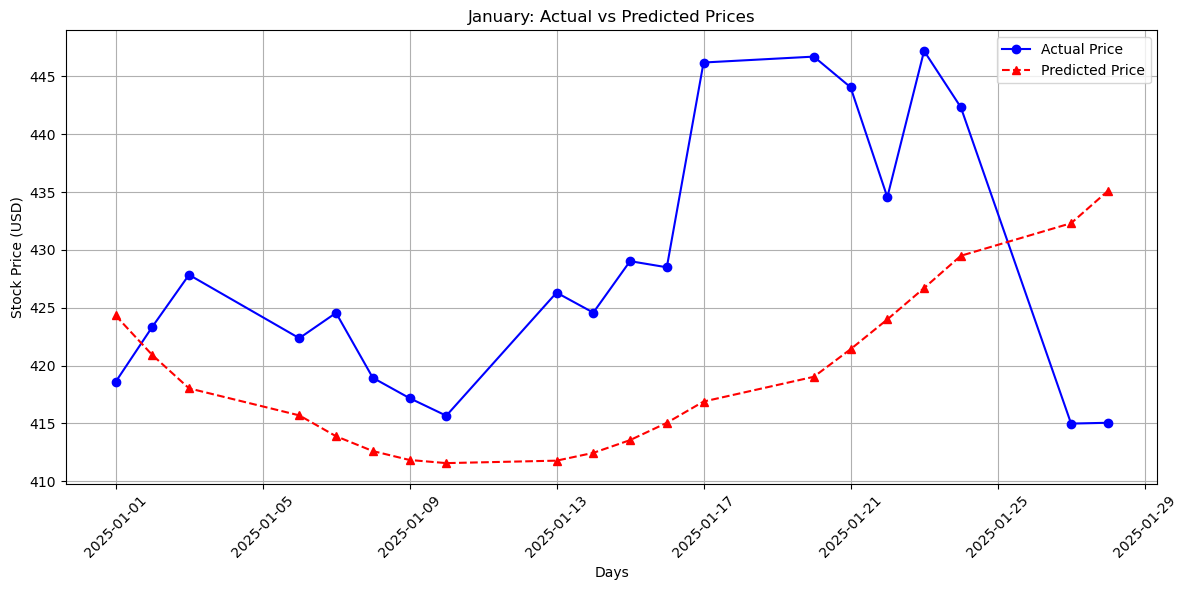

         Date  Actual   Predicted
0  2025-01-01  418.58  424.339844
1  2025-01-02  423.35  420.919586
2  2025-01-03  427.85  418.036346
3  2025-01-06  422.37  415.699219
4  2025-01-07  424.56  413.896545
5  2025-01-08  418.95  412.615173
6  2025-01-09  417.19  411.844452
7  2025-01-10  415.67  411.573181
8  2025-01-13  426.31  411.785736
9  2025-01-14  424.58  412.458679
10 2025-01-15  429.03  413.561401
11 2025-01-16  428.50  415.055267
12 2025-01-17  446.20  416.895905
13 2025-01-20  446.71  419.034302
14 2025-01-21  444.06  421.418274
15 2025-01-22  434.56  423.993530
16 2025-01-23  447.20  426.704224
17 2025-01-24  442.33  429.494812
18 2025-01-27  414.99  432.309814
19 2025-01-28  415.06  435.096375
Could not load January data for comparison: 'DataFrame' object has no attribute 'tocsv'
Skipping January comparison section.


In [54]:
# 14. Comparing predictions with actual January data (if available)
try:
    jan_df = pd.read_csv('actual_jan.csv')
    jan_msft = jan_df[jan_df['symbol'] == 'MSFT']
    jan_close = jan_msft.reset_index()['close']
    
    actual_jan = jan_close[:future_days].values
    
    # Creating comparison DataFrame
    comparison_df = pd.DataFrame({
        'Date': pd.date_range(start='2025-01-01', periods=20, freq='B'),
        'Actual': actual_jan,
        'Predicted': future_predictions_actual.flatten()
    })
    
    #error metrics
    jan_rmse = math.sqrt(mean_squared_error(actual_jan, future_predictions_actual))
    jan_mape = np.mean(np.abs((actual_jan - future_predictions_actual.flatten()) / actual_jan)) * 100
    
    print(f'January Prediction RMSE: {jan_rmse:.2f}')
    print(f'January Prediction MAPE: {jan_mape:.2f}%')
    
    #actual vs predicted January prices
    plt.figure(figsize=(12, 6))
    plt.title('January: Actual vs Predicted Prices')
    plt.plot(comparison_df['Date'], comparison_df['Actual'], 'b-o', label='Actual Price')
    plt.plot(comparison_df['Date'], comparison_df['Predicted'], 'r--^', label='Predicted Price')
    plt.xlabel('Days')
    plt.ylabel('Stock Price (USD)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    print(comparison_df)
    
except Exception as e:
    print(f"Could not load January data for comparison: {e}")
    print("Skipping January comparison section.")

In [61]:
comparison_df.to_csv('LSTM_Results.csv')

In [52]:
#Sharpe Ratio
#daily returns from predicted prices
comparison_df["Predicted_Return"] = comparison_df["Predicted"].pct_change()

# 2% Annula risk
risk_free_rate = 0.02 / 252  # 252 trading days

# Step 3: Excess returns
comparison_df["Excess_Return"] = comparison_df["Predicted_Return"] - risk_free_rate

# Step 4: Calculate Sharpe Ratio
mean_excess_return = comparison_df["Excess_Return"].mean()
std_excess_return = comparison_df["Excess_Return"].std()
sharpe_ratio = mean_excess_return / std_excess_return

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.2505
